### Using Gaussian Mixture Models

** Working of Gaussian Mixture Models (Algorithm) **
1. Fit the black box using the original dataset
2. Generate a random dataset under some constraints using the minimum and maximum values of features
3. Generate labels for the random dataset using the black box
4. Partition the random dataset for 100 datapoints for each of the classes
5. Merge the partitions with previous distribution (if any) to form a new distribution, say dist
6. Fit a Gaussian Mixture Model using the dist
7. Generate a random dataset using the GMM fit above and its corresponding distribution (as in step 5) and call it previous distribution
8. Go to step 3

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.mixture import GaussianMixture

In [2]:
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

In [3]:
## Using the IRIS dataset
iris = datasets.load_iris()

In [4]:
X = iris.data
y = iris.target
print X.shape, y.shape

(150, 4) (150,)


[]

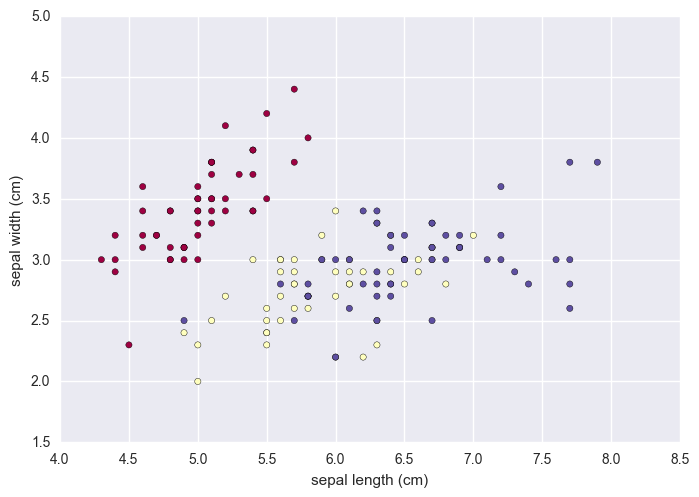

In [5]:
plt.scatter(X[:, 0], X[:, 1],c=y, cmap=plt.cm.Spectral)
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1])
plt.plot()

In [6]:
def generate_random(orig_data, feature_names, data_size):
    '''
    Input: Data, Feature Names, Size of Random Data
    Output: Random Data
    
    Generates random dataset of size data_size
    Random dataset is generated from normal
    distribution with specified high and low values
    '''
    
    df = {}
    for i in range(len(feature_names)):
        low = np.min(orig_data[:, i])
        high = np.max(orig_data[:, i])
        df[feature_names[i]] = np.random.uniform(low=low, high=high, size=data_size)
    random_dataset = pd.DataFrame(data=df, columns=df.keys())
    
    return random_dataset

In [7]:
def whiteBox(blackbox, whitebox, X, y, X_random):
    '''
    Input: Black Box model, Data, Labels, Random Data
    Output: Random Data labels
    
    Construct a white box and fits it on random data
    Checks the performance of white box
    Returns random data labels
    '''
    
    y_random = blackbox.predict(X_random)
    whitebox.fit(X_random, y_random)
    score = whitebox.score(X, y)
    print 'Accuracy on Black Box: ', score
    
    return y_random

In [8]:
def genDistribution(X_random, y_random, dist_size, dist=None):
    '''
    Input: Random Dataset, Bbox generated labels
    Size of distribution, Previous distribution (if any)
    
    Output: Distribution of dist_size from each of the
    corresponding labels of the original dataset
    
    '''
    
    for label in np.unique(y_random):
        temp = X_random[y_random == label, :]
        print 'Label: ',label, ' Shape of Slice: ',temp.shape
        try:
            dist = np.vstack((dist, temp[:dist_size, :]))
        except:
            dist = temp[0:dist_size, :]
    print 'Final Array Shape: ', dist.shape
    
    return dist

In [9]:
def fitGMM(dist, n_samples=100000):
    '''
    Input: Distribution for fitting GMM,
    No. of samples
    
    Output: Random Dataset using fitted GMM
    
    Fits the GMM on new distribution generated
    and returns a sample of size n_samples
    
    '''
    
    gmm = GaussianMixture(n_components=1)
    gmm.fit(dist)
    X_random = gmm.sample(n_samples=10000)[0]
    
    return X_random

In [10]:
def produceGMM(blackbox, X, y, X_random, dist):
    
    '''
    Input: Black box model, Data, Labels, Random dataset
    Distribution
    
    Output: Random dataset and new distribution
    
    Works according to the README described above
    
    '''
    
    whitebox = RandomForestClassifier()
    y_random = whiteBox(blackbox, whitebox, X, y, X_random)
    dist = genDistribution(X_random, y_random, dist_size=100, dist=dist)
    X_random = fitGMM(dist)
    
    return X_random, dist

In [20]:
X_random = generate_random(X, feature_names=iris.feature_names, data_size=100000).values
print X_random.shape

(100000, 4)


In [21]:
blackbox = RandomForestClassifier()
blackbox.fit(X, y)
print 'Training Accuracy: ', blackbox.score(X, y)

Training Accuracy:  0.993333333333


In [22]:
whitebox = RandomForestClassifier()
y_random = whiteBox(blackbox, whitebox, X, y, X_random)

c = Counter(y_random)
print 'Distribution of LABELS:'
for k,v in c.iteritems():
    print 'Label: ',k,' Count: ',v

Accuracy on Black Box:  0.526666666667
Distribution of LABELS:
Label:  0  Count:  98982
Label:  1  Count:  901
Label:  2  Count:  117


In [23]:
N_EPOCHS = 5
dist = None
random = X_random
for i in range(N_EPOCHS):
    print '*'*50
    print 'Epoch: ', i+1
    random, dist = produceGMM(blackbox, X, y, random, dist=dist)

**************************************************
Epoch:  1
Accuracy on Black Box:  0.513333333333
Label:  0  Shape of Slice:  (98982, 4)
Label:  1  Shape of Slice:  (901, 4)
Label:  2  Shape of Slice:  (117, 4)
Final Array Shape:  (300, 4)
**************************************************
Epoch:  2
Accuracy on Black Box:  0.72
Label:  0  Shape of Slice:  (7306, 4)
Label:  1  Shape of Slice:  (1568, 4)
Label:  2  Shape of Slice:  (1126, 4)
Final Array Shape:  (600, 4)
**************************************************
Epoch:  3
Accuracy on Black Box:  0.7
Label:  0  Shape of Slice:  (5954, 4)
Label:  1  Shape of Slice:  (2117, 4)
Label:  2  Shape of Slice:  (1929, 4)
Final Array Shape:  (900, 4)
**************************************************
Epoch:  4
Accuracy on Black Box:  0.7
Label:  0  Shape of Slice:  (5447, 4)
Label:  1  Shape of Slice:  (2322, 4)
Label:  2  Shape of Slice:  (2231, 4)
Final Array Shape:  (1200, 4)
**************************************************
Epoch:  5